In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn.functional import mse_loss, l1_loss
from scipy.stats import norm
from scipy.stats import entropy
from scipy import stats
import random
import matplotlib
import argparse
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
import pandas as pd
from tqdm import tqdm
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

# import imageio
import os
import sys

from cdf import CDF
import protector as protect


dtype = torch.FloatTensor

In [3]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = argparse.Namespace()
args.device = device
args.eps_clip = 1.8
args.gamma = 1 / (8 * sqrt(3))
args.match_plus_plus = False

In [4]:
exp_list = [
    {
        'exp_name': 'In distribution',
        'mu0': -1,
        'sig0': 1,
        'mu1': 1,
        'sig1': 1,
        'test_bias': 0
    },
    {
        'exp_name': 'Out of distribution',
        'mu0': -1,
        'sig0': 1,
        'mu1': 1,
        'sig1': 1,
        'test_bias': 1
    },
]

for exp_dict in exp_list:
    cls0_mu = exp_dict['mu0']
    cls0_sig = exp_dict['sig0']
    
    cls1_mu = exp_dict['mu1']
    cls1_sig = exp_dict['sig1']
    exp_dict['beta'] = (cls1_mu - cls0_mu) / cls0_sig
    exp_dict['gamma'] = -0.5 * (cls1_mu - cls0_mu) * (cls1_mu + cls0_mu ) / cls1_sig


In [5]:
def calc_ents(p):
    return -(p * torch.log2(p) + (1 - p) * torch.log2(1 - p))

def calc_p(x, b, beta, gamma):
    z = beta * (x - b) + gamma
    p = z.sigmoid()

    eps = 1e-10
    p = torch.clamp(p, eps, 1 - eps)
    return p


def calc_acc_with_boundary(x, y, decision_line: float = 0.):
    pred = np.zeros_like(x)
    pred[x > decision_line] = 1

    acc = (pred.flatten() == y).sum() / y.shape[0]
    return acc



def get_df(cls0_x, cls1_x, beta, gamma):

    p = calc_p(torch.hstack([torch.from_numpy(cls0_x), torch.from_numpy(cls1_x)]), 0, beta, gamma)
    # ents = calc_ents(p, 0)
    ents = calc_ents(p)
    
    d = {
        'x': np.hstack([cls0_x, cls1_x]),
        'y': np.hstack([np.zeros_like(cls0_x), np.ones_like(cls0_x)]).astype(int),
        'pred': p,
        'ents': ents,
    }
    
    df = pd.DataFrame(d)

    return df


def generate_exp_data(exp_dict, n_samples: int = 10000):
    # DATA CREATION
    cls0_mu = exp_dict['mu0']
    cls0_sig = exp_dict['sig0']
    cls0_x_tr = np.random.normal(cls0_mu, cls0_sig, (n_samples, ))
    
    cls1_mu = exp_dict['mu1']
    cls1_sig = exp_dict['sig1']
    cls1_x_tr = np.random.normal(cls1_mu, cls1_sig, (n_samples, ))
    
    pi0 = cls0_x_tr.shape[0] / (cls0_x_tr.shape[0] + cls1_x_tr.shape[0])
    pi1 = cls1_x_tr.shape[0] / (cls0_x_tr.shape[0] + cls1_x_tr.shape[0])
    
    beta = exp_dict['beta']
    gamma = exp_dict['gamma']
    
    pi = pi1 / pi0

    
    train_df = get_df(cls0_x_tr, cls1_x_tr, beta, gamma)
    train_df = train_df.sample(frac=1)

    cls0_x_ho = np.random.normal(cls0_mu, cls0_sig, (n_samples // 4, ))
    cls1_x_ho = np.random.normal(cls1_mu, cls1_sig, (n_samples // 4, ))

    holdout_df = get_df(cls0_x_ho, cls1_x_ho, beta, gamma)
    holdout_df = holdout_df.sample(frac=1)

    test_bias = exp_dict['test_bias']
      
    
    # TEST DATA
    cls0_x_te = np.random.normal(cls0_mu + test_bias, cls0_sig, (n_samples, ))
    cls1_x_te = np.random.normal(cls1_mu + test_bias, cls1_sig, (n_samples, ))
    
    test_df = get_df(cls0_x_te, cls1_x_te, beta, gamma)
    test_df = test_df.sample(frac=1)

    return train_df, holdout_df, test_df



def run_optimization(holdout_df, test_df, method, exp_dict):
    protector = protect.get_protector_from_ents(holdout_df.ents, args)

    beta, gamma = exp_dict['beta'], exp_dict['gamma']
    bias = Variable(torch.tensor([0.]).type(dtype), requires_grad=True)
    lr = 5
    steps = 200
    pbar = tqdm(range(steps))

    losses = []
    
    for i in pbar:

        sample = np.array(test_df.sample(64).x)
        
        tensor_x = torch.tensor(sample, requires_grad=True)

        probs = calc_p(tensor_x, bias, beta, gamma)
        ents = calc_ents(probs)

        if method == 'pem':
            protected_ents, protection_info = protector.protect(ents.detach())
            loss = 0.5 * torch.nn.functional.mse_loss(ents.view(-1), protected_ents.view(-1))

            # e = torch.exp(beta * (tensor_x - bias) + gamma)
            # derivative = 2 * (ents - protected_ents.cpu()) * (torch.log2(1 - probs) - torch.log2(probs)) * ((-beta * e) / (1 + e)**2)
            # print(derivative.mean().item())
        else:
            loss = ents.mean()

        losses.append(loss.item())
            
        pbar.set_description(f"{loss.item() = :.3f}, {bias.item() = :.3f}")
        
        acc = calc_acc_with_boundary(test_df.x, test_df.y, bias.item())        

        loss.backward()
        # print(bias.grad.data)
        bias.data -= lr * bias.grad.data
    
        # Manually zero the gradients after updating weights
        bias.grad.data.zero_()

    # print(losses)
    
    return bias.item()


def run_exp(train_df, holdout_df, test_df, exp_dict):
    original_cdf = CDF(np.array(train_df.ents).flatten())
    test_bias = exp_dict['test_bias']   
    
    s = min(test_df.x.min(), train_df.x.min())
    e = max(test_df.x.max(), train_df.x.max())
    
    cs = list(np.linspace(s - 3, test_bias, 500)) + list(np.linspace(test_bias, e + 3, 500))
    
    our_losses = []
    reg_losses = []
    grads = []
    ders = []

    beta = exp_dict['beta']
    gamma = exp_dict['gamma']

    protector = protect.get_protector_from_ents(holdout_df.ents, args)
    
    pbar = tqdm(cs)
    for c in pbar:
        protector.reset()
        bias = Variable(torch.tensor([c]).type(dtype), requires_grad=True)
    
        sample = np.array(test_df.sample(frac=1.).x)
        tensor_x = torch.tensor(sample, requires_grad=False)
        
        probs = calc_p(tensor_x, bias, beta, gamma)
        ents = calc_ents(probs)
    
        test_cdf = CDF(ents.detach().numpy())
        protected_ents = torch.tensor(original_cdf.inverse(test_cdf(ents.detach().numpy())))
        # protected_ents, protection_info = protector.protect(ents.detach())
        
        loss = mse_loss(ents, protected_ents.cpu())
        # loss = mse_loss(ents, torch.zeros_like(ents).type(torch.float64).cpu())
        e = torch.exp(beta * (tensor_x - bias) + gamma)
        derivative = 2 * (ents - protected_ents.cpu()) * (torch.log2(1 - probs) - torch.log2(probs)) * ((-beta * e) / (1 + e)**2) 
        ders.append(derivative.mean().item())
    
        loss.backward()
        grads.append(bias.grad.data.item())
        
        our_losses.append(loss.item())
        reg_losses.append(ents.mean().item())
        bias.grad.data.zero_()

    results = {
        'our_losses': our_losses,
        'reg_losses': reg_losses,
        'cs': cs,
        'ders': ders
    }

    return results

    
    

In [6]:
# PLOTTING
def plot_exp_data(train_df, test_df):
    plt.figure(figsize=(10,6))
    ax = sns.histplot(train_df, x=train_df.x, hue=train_df.y)
    ax2 = plt.twinx(ax)
    ax = sns.lineplot(train_df, x=train_df.x, y=train_df.ents, ax=ax2, color='k', alpha=0.50, label='entropy(x)')
    ax = sns.lineplot(train_df, x=train_df.x, y=train_df.pred, ax=ax2, color='r', alpha=0.70, label="$P(Y=1 | X)$")
    ax.axvline(0, 0, 160, color='k', alpha=0.50, linestyle='--', label='decision line')
    plt.legend()
    plt.title('train set')
    plt.show()
    plt.close()
    
    plt.figure(figsize=(10,6))
    ax = sns.histplot(test_df, x='x', hue='y')
    ax2 = plt.twinx(ax)
    # ax = sns.lineplot(test_df, x=test_df.x, y=test_df.ents, ax=ax2, color='k', alpha=0.50)
    ax = sns.lineplot(test_df, x='x', y='ents', ax=ax2, color='k', alpha=0.50, label='entropy(x)')
    ax = sns.lineplot(test_df, x='x', y='pred', ax=ax2, color='r', alpha=0.70, label="$P(Y=1 | X)$")
    ax.axvline(0, 0, 160, color='k', alpha=0.50, linestyle='--', label='decision line')
    plt.legend()
    plt.title('test set')
    # ax.arrow(0, 1200, 3, 0)
    plt.show()
    plt.close()


def find_closest_index(values, target_value):
    # Calculate the absolute difference between each value in the list and the target value
    differences = [abs(value - target_value) for value in values]
    # Find the index of the smallest difference
    closest_index = differences.index(min(differences))
    return closest_index


def plot_exp_results(ax1, train_df, test_df, exp_results, exp, x_min, x_max, draw_ticks: bool = False):
    # Data for plotting
    cs = np.array(exp_results['cs']).flatten()
    reg_losses = np.array(exp_results['reg_losses']).flatten()
    our_losses = np.array(exp_results['our_losses']).flatten()
    derivatives = np.array(exp_results['ders']).flatten()

    # Filter the data to only include values within the x-range
    valid_indices = (cs >= x_min) & (cs <= x_max)
    cs = cs[valid_indices]

    y0 = norm.pdf(cs, exp['mu0'] + exp['test_bias'], exp['sig0'])
    y1 = norm.pdf(cs, exp['mu1'] + exp['test_bias'], exp['sig1'])

    ax1.fill_between(cs, y0, label=f'Class -{1}', color='#d7e2e7', alpha=0.5)
    ax1.fill_between(cs, y1, label=f'Class +{1}', color='#8d99ae', alpha=0.5)
    
    reg_losses = reg_losses[valid_indices]
    our_losses = our_losses[valid_indices]
    derivatives = derivatives[valid_indices]

    # # Custom color palette for different 'y' values
    # palette = {0: "#D7E2E7", 1: "#8d99ae"}  # Replace 'blue' and 'green' with your colors

    # for cls in [0, 1]:
    #     class_data = test_df[test_df['y'] == cls]['x']
    #     sns.kdeplot(class_data, color=palette[cls], fill=True, ax=ax1, alpha=0.75, label=f'Class {cls}')

    # Scaling the loss curves relative to plot dimensions
    max_y_value = max(ax1.get_ylim())
    scale_factor = max_y_value / max(max(reg_losses), max(our_losses), max(derivatives))
    scaled_reg_losses = reg_losses * scale_factor
    scaled_our_losses = our_losses * scale_factor
    scaled_derivatives = derivatives * scale_factor

    # Plotting scaled loss curves on the same axis as the KDE
    our_color = '#ef233c'
    reg_color = '#2b2d42'
    
    # Plotting scaled loss curves on the same axis as the histogram
    ax1.plot(cs, scaled_reg_losses, reg_color, alpha=1., label=r'$\mathbf{\mathrm{\mathbb{E}}}[\ell^{ent}]$', linewidth=2)
    ax1.plot(cs, scaled_our_losses, our_color, alpha=1., label=r'$\mathbf{\mathrm{\mathbb{E}}}[\ell^{match}]$', linewidth=2)
    # ax1.plot(cs, scaled_reg_losses, reg_color, alpha=1., label=r'$E[\ell^{ent}]$', linewidth=2)
    # ax1.plot(cs, scaled_our_losses, our_color, alpha=1., label=r'$E[\ell^{match}]$', linewidth=2)


    # Directly plot minima points and annotations
    def plot_minima(c_value, cs, losses, color, label, ax1, x_min, x_max):
        # Ensure the axes and limits are provided correctly
        if not ax1:
            fig, ax1 = plt.subplots()
        
        # Find the index if c_value exists in cs, otherwise interpolate
        if c_value in cs:
            index = cs.index(c_value)
            min_loss = losses[index]
            min_c = c_value
        else:
            # Interpolating to find the loss at c_value
            if c_value < x_min:
                c_value = min(cs) + 0.12
            if c_value > x_max:
                c_value = max(cs) - 0.12
                
            interpolate = interp1d(cs, losses, kind='linear')
            min_loss = interpolate(c_value)
            min_c = c_value
        

        # Assuming calc_acc_with_boundary function exists and calculates accuracy
        acc = calc_acc_with_boundary(test_df['x'].values, test_df['y'].values, min_c)
        
        # Plotting the minimum point
        ax1.plot(min_c, min_loss, color=color, marker='*', markersize=12, markeredgecolor="#212121", linewidth=0.80)

        # # Determine horizontal alignment and adjust annotation text position dynamically
        ha = 'right' if min_c > 0.95 * x_max else 'left' if min_c < 0.05 * x_min else 'center'
        xytext = (-20, 10) if ha == 'right' else (20, 10) if ha == 'left' else (0, 10)
        ax1.annotate(
            f'{label} Acc - {acc:.2f}', 
            xy=(min_c, min_loss), 
            xytext=xytext,
            textcoords="offset points",
            fontsize=11,
            ha=ha,
            va='bottom',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor=color, alpha=0.8),
            # arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5", color=color)
        ).set_clip_on(True)


    # Adding vertical dashed line at x=0
    ax1.axvline(x=0, linestyle='--', color='#F0B719', label='No-Adapt')
    no_adapt_accuracy = calc_acc_with_boundary(test_df['x'].values, test_df['y'].values, 0)
    ax1.annotate(f'No-Adapt Acc - {no_adapt_accuracy:.2f}', xy=(0, max(ax1.get_ylim())), textcoords="offset points", xytext=(0,-30), ha='center', fontsize=11,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.85))
    
    # Finding convergence points and plotting
    our_res = run_optimization(holdout_df, test_df, 'pem', exp)
    ent_res = run_optimization(holdout_df, test_df, 'ent', exp)
    
    plot_minima(our_res, cs, scaled_our_losses, our_color, 'Ent Matching', ax1, x_min, x_max)
    plot_minima(ent_res, cs, scaled_reg_losses, reg_color, 'Ent Min.', ax1, x_min, x_max)
    
    y_max = max(ax1.get_ylim())
    ax1.set_ylim(- 6 * (y_max / 100), y_max + (y_max / 100))
    ax1.set_xlim(x_min, x_max) 
    ax1.set_yticks([])
    ax1.set_ylabel('Risk', fontsize=13)
    ax1.set_xlabel(r'$X$ (also $\omega$)', fontsize=13)

    # Adding the legend with specific font size
    # legend = ax1.legend(fontsize=7, loc='upper right')  # You can also use numeric values like 10
    # legend = ax1.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    legend = ax1.legend(bbox_to_anchor=(0, 1), loc="upper left")

    
    # Adjust legend border padding
    legend.get_frame().set_linewidth(0.5)  # Adjust border width
    legend.get_frame().set_edgecolor('black')  # Change border color
    
    # Optionally adjust padding within the legend box
    legend._legend_box.sep = 5  # Adjusts the spacing between items
    legend._legend_box.align = "left"  # Align text to the left
    
    # ax1.set_title(exp['exp_name'], fontsize=10)

    if not draw_ticks:
        ax1.get_xaxis().set_visible(False)
    else:
        ax1.get_legend().remove()

    # # Add legend and adjust its appearance
    # legend = ax1.legend(fontsize='small', loc='upper right')
    # legend.get_frame().set_linewidth(0.5)
    # legend.get_frame().set_edgecolor('black')

    return ax1





2024-05-20 16:33:54.617 | INFO     | protector:get_protector_from_ents:144 - creating protector from ents
2024-05-20 16:33:54.619 | INFO     | protector:set_gamma:46 - setting gamma val to 0.07216878364870323
2024-05-20 16:33:54.620 | INFO     | protector:set_eps_clip_val:42 - setting epsilon clip val to 1.8
100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 76.60it/s]
2024-05-20 16:34:07.769 | INFO     | protector:get_protector_from_ents:144 - creating protector from ents
2024-05-20 16:34:07.771 | INFO     | protector:set_gamma:46 - setting gamma val to 0.07216878364870323
2024-05-20 16:34:07.772 | INFO     | protector:set_eps_clip_val:42 - setting epsilon clip val to 1.8
loss.item() = 0.000, bias.item() = -0.015: 100%|█████████████████████████████████| 200/200 [00:04<00:00, 44.49it/s]
2024-05-20 16:34:12.271 | INFO     | protector:get_protector_from_ents:144 - creating protector from ents
2024-05-20 16:34:12.273 | INFO     | prote

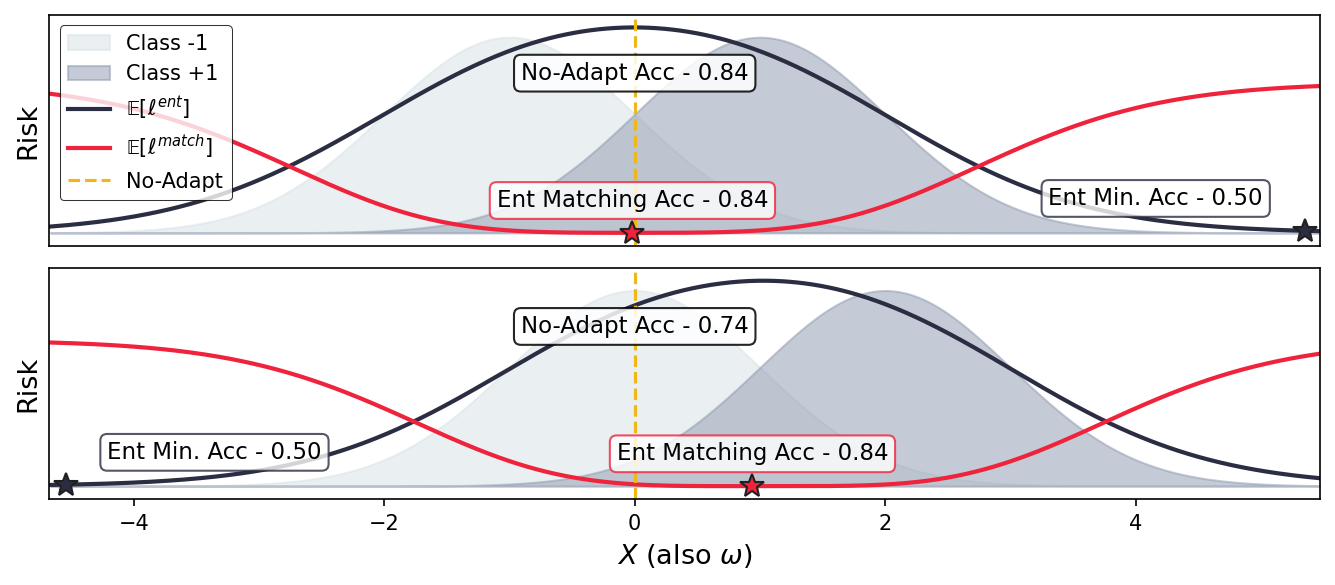

In [7]:


data_list = [generate_exp_data(exp) for exp in exp_list]

# Determine the global x-axis limits
global_x_min = min(test_df['x'].min() for _, _, test_df in data_list)
global_x_max = max(test_df['x'].max() for _, _, test_df in data_list)

fig, axs = plt.subplots(2, 1, figsize=(9, 4), dpi=150)  # Adjust figsize as needed
axs = axs.flatten()  # Flatten the 2x2 array of axes into a 1D array



train_df, holdout_df, test_df = generate_exp_data(exp_list[0])
exp_results = run_exp(train_df, holdout_df, test_df, exp_list[0])
plot_exp_results(axs[0], train_df, test_df, exp_results, exp_list[0], global_x_min, global_x_max)

train_df, holdout_df, test_df = generate_exp_data(exp_list[1])
exp_results = run_exp(train_df, holdout_df, test_df, exp_list[1])
plot_exp_results(axs[1], train_df, test_df, exp_results, exp_list[1], global_x_min, global_x_max, draw_ticks=True)

plt.tight_layout()
plt.savefig('figures/synth_exp.svg', format='svg')
plt.show()